In [3]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

from tensorflow import keras

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

In [5]:

# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


In [16]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('D:/DataWorld/My Code/git/NLP/NLP - Basics/glove.6B.100d.txt', encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
       
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
    
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [17]:

# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("train.csv")
train

Loading in comments...


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [19]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [26]:
sentences = train["comment_text"].values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [27]:
sentences

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [30]:
targets

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [32]:
targets.shape, sentences.shape

((159571, 6), (159571,))

In [41]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()

In [87]:
len(sequences[2]), len(sentences[2].split())

(42, 42)

In [49]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [56]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [165]:
len(sequences)

159571

In [76]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [172]:
data.max()

19999

In [88]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [167]:
embedding_matrix.shape

(20000, 100)

In [102]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,    # 20000
  EMBEDDING_DIM,   # 100
  weights=[embedding_matrix],    # (20000, 100)
  input_length=MAX_SEQUENCE_LENGTH, # 100
  trainable=False
)

In [103]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Building model...


In [104]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 39s 32ms/step - loss: 0.1056 - accuracy: 0.9396 - val_loss: 0.0880 - val_accuracy: 0.9939
Epoch 2/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0679 - accuracy: 0.9917 - val_loss: 0.0743 - val_accuracy: 0.9935
Epoch 3/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0633 - accuracy: 0.9936 - val_loss: 0.0761 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 32s 32ms/step - loss: 0.0593 - accuracy: 0.9939 - val_loss: 0.0670 - val_accuracy: 0.9937
Epoch 5/10
998/998 [==============================] - 33s 33ms/step - loss: 0.0554 - accuracy: 0.9936 - val_loss: 0.0743 - val_accuracy: 0.9940: 0.0545 - accurac - ETA: 18s - loss: 0.0546 - accuracy: - E - ETA: 15s - loss:  - ETA: 14s - loss: 0.0548 - accur - ETA: 13s - loss: 0.05 - ETA: 7s - los - ETA: 6s - loss: 0.0551 - accuracy: 0.99 - ETA: 6s - l - ETA: 5s - - ETA: 1s - loss: 0.0553 - accu - ETA: 1

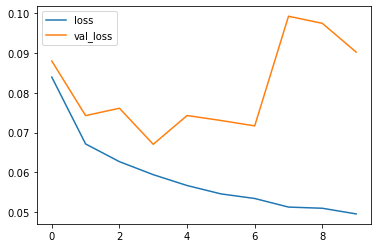

In [105]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

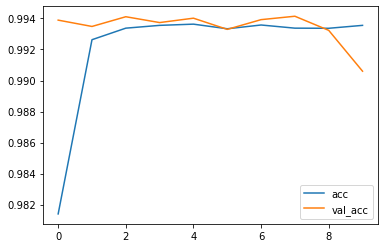

In [106]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [107]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9742518571243174


In [124]:
p[12]>0.4

array([False, False, False, False, False, False])

In [127]:
targets[:,1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [125]:
aucs

[0.966262612222477,
 0.9861837669719443,
 0.9777911507950436,
 0.9644876143731831,
 0.9764390882964932,
 0.9743469100867628]

In [146]:
sum(np.array(sorted(targets.sum(axis=1),reverse=True)) == 0)

143346

In [148]:
p.shape

(159571, 6)

In [149]:
targets.shape

(159571, 6)

In [ ]:
In [1]: from keras.preprocessing.text import Tokenizer
In [2]: texts = ['a a a', 'b b', 'c']
In [3]: tokenizer = Tokenizer(num_words=2)
In [4]: tokenizer.fit_on_texts(texts)
In [5]: tokenizer.word_index
Out[5]: {'a': 1, 'b': 2, 'c': 3}
In [6]: tokenizer.texts_to_sequences(texts)
Out[6]: [[1, 1, 1], [], []]

In [173]:
texts = ['a a a', 'b b', 'c']

In [178]:
tokenizer = Tokenizer(num_words=3)

In [179]:
tokenizer.fit_on_texts(texts)

In [180]:
tokenizer.word_index

{'a': 1, 'b': 2, 'c': 3}

In [181]:
tokenizer.texts_to_sequences(texts)

[[1, 1, 1], [2, 2], []]